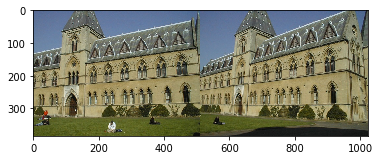

297
Average residual : 0.34379518433485723


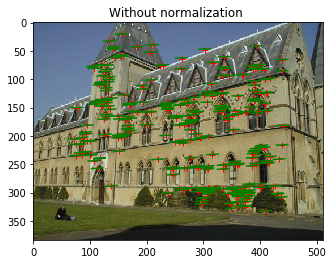

c:\users\34658\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in log


309
Average residual : 0.05017954860340517


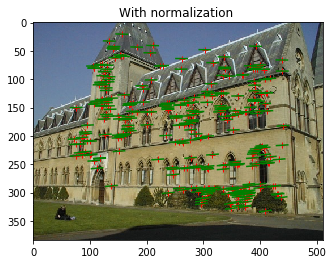

In [177]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform
import random
##
## load images and match files for the first example
##

I1 = Image.open('library1.jpg');
I2 = Image.open('library2.jpg');
matches = np.loadtxt('library_matches.txt'); 

# this is a N x 4 file where the first two numbers of each row
# are coordinates of corners in the first image and the last two
# are coordinates of corresponding corners in the second image: 
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is a corresponding point in the second image

N = len(matches)

##
## display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
##

I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I3).astype("uint8"))
# ax.plot(matches[:,0],matches[:,1],  '+r')
# ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
# ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
plt.show()
##
## display second image with epipolar lines reprojected 
## from the first image
##
def fit_fundamental(matches, l_size=None, r_size=None):
    def ransac_fundamental(indices, threshold, max_iterations=300000):
        '''
        @indices: a N x 2 x 2 matrix, where each line is x' and x. We want to \
        find the least square solution of lambda x' = Hx
        @threshold: the maximum distance of inliers
        '''
        def augment(data):
            aug_data = np.ones((len(data), 3), dtype=np.float64)
            aug_data[:,:2] = data
            return aug_data
        
        def is_inlier(model, x, x_p, threshold=threshold):
            L1 = (x @ model.T).reshape(-1, 3)
            l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
            L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())
            pt_line_dist = np.multiply(L, x_p).sum(axis = 1)
            
            return np.count_nonzero(pt_line_dist <= threshold)

        num_points = len(indices)
        max_num_inliers = 0
        min_samples = 8
        x, x_p = augment(indices[:,:2]), augment(indices[:,2:])
        
        # Construct A
        A = np.ones((len(matches), 9))
        for i in range(len(matches)):
            A[i] = np.kron(x_p[i], x[i]).reshape(-1)
        # print(A)
        
        # Adaptive RANSAC
        N = float('inf')
        sample_count = 0
        N= 1
        optim_model = None
        optim_inliers_idx = []
        while N > sample_count and sample_count < max_iterations:
            rand_index = random.sample(range(num_points), min_samples)
            
            # Solve for Ah = 0
            # Construct A_sample
            A_sample = np.zeros((min_samples, 9), dtype=np.float64)
            for i in range(min_samples):
                A_sample[i] = A[rand_index[i]]
            
            # Get the eigenvector lf A^TA corresponding to the smallest eigenvalue
            # This is equivalent to get the vector in V (SVD of A) corresponding to the smallest singular value
            model = np.linalg.svd(A_sample)[-1][-1,:].reshape((3, 3))
            
            # normalize the last element of the model to 1, it seems unnecessary? 
            model /= model[-1][-1]
            # print(model)
            
            num_inliers = is_inlier(model, x, x_p, threshold)
            if num_inliers > max_num_inliers:
                max_num_inliers = num_inliers
                optim_model = model
                N = np.log(0.05) / np.log(1 - np.power(num_inliers / num_points, min_samples))
                
            sample_count += 1
        
        for i in range(num_points):
            if is_inlier(optim_model, x[i], x_p[i], threshold):
#                     print(i)
                    optim_inliers_idx.append(i)
                    
        # Refit all inliers
        A_sample = np.zeros((len(optim_inliers_idx), 9), dtype=np.float64)
        for i in range(len(optim_inliers_idx)):
            A_sample[i] = A[optim_inliers_idx[i]]
        optim_model = np.linalg.svd(A_sample)[-1][-1,:].reshape((3, 3))
        u, s, vh = np.linalg.svd(optim_model)
        optim_model = u[:, :2] @ np.diag(s[:2]) @ vh[:2, :]
        print(len(optim_inliers_idx))
        return optim_model, np.array(optim_inliers_idx)
    
    # Normalization
    if l_size and r_size:
        l_size = np.array(l_size)
        r_size = np.array(r_size)
        hl_size, hr_size = l_size / 2, r_size / 2
        scale_l = np.sqrt((hl_size[0] * (hl_size[0] + 1) * (2 * hl_size[0] + 1) + \
                          hl_size[1] * (hl_size[1] + 1) * (2 * hl_size[1] + 1)) / \
                          (3 * 4 * hl_size[0] * hl_size[1]))
        scale_r = np.sqrt((hr_size[0] * (hr_size[0] + 1) * (2 * hr_size[0] + 1) + \
                          hr_size[1] * (hr_size[1] + 1) * (2 * hr_size[1] + 1)) / \
                          (3 * 4 * hr_size[0] * hr_size[1]))
        T_l = np.array([[1/scale_l, 0, 0],\
                        [0, 1/scale_l, 0],\
                        [0, 0, 1]]) @ \
              np.array([[1, 0, -hl_size[0]],\
                        [0, 1, -hl_size[1]],\
                        [0, 0, 1]])
        
        T_r = np.array([[1/scale_r, 0, 0],\
                        [0, 1/scale_r, 0],\
                        [0, 0, 1]]) @ \
              np.array([[1, 0, -hr_size[0]],\
                        [0, 1, -hr_size[1]],\
                        [0, 0, 1]])
        
        n_matches = np.empty_like(matches)
        n_matches[:,:2] = (T_l @ np.c_[matches[:, :2], np.ones((len(matches), 1))].T).T[:, :2]
        n_matches[:,2:] = (T_r @ np.c_[matches[:, 2:], np.ones((len(matches), 1))].T).T[:, :2]
        model, inliers = ransac_fundamental(n_matches, 1)
#         model, inliers = ransac((n_matches[:,:2], n_matches[:,2:]), FundamentalMatrixTransform, min_samples=8,
#                                   residual_threshold=1, max_trials=1000)
#         model = model.params
        
        return T_r.T @ model @ T_l
    # Without normalization
    else:
        model, inliers = ransac_fundamental(matches, 1)
        return model
# first, fit fundamental matrix to the matches
F = fit_fundamental(matches); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())
print("Average residual :", np.mean(pt_line_dist))

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I2).astype("uint8"))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.title("Without normalization ")
plt.show()


F = fit_fundamental(matches, l_size=I1.size, r_size=I2.size); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())
print("Average residual :", np.mean(pt_line_dist))

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I2).astype("uint8"))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.title("With normalization ")
plt.show()



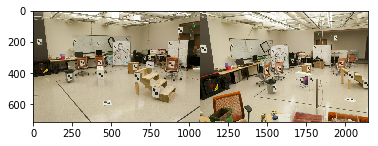

Average residual : 2.0925143029903195


c:\users\34658\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log


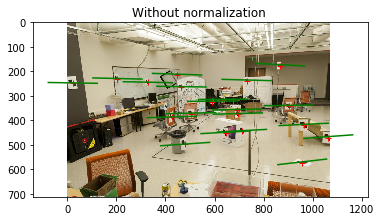

Average residual : -0.17715751749912415


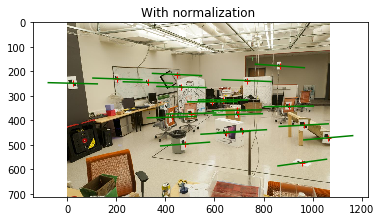

In [180]:
I1 = Image.open('lab1.jpg');
I2 = Image.open('lab2.jpg');
matches = np.loadtxt('lab_matches.txt'); 

# this is a N x 4 file where the first two numbers of each row
# are coordinates of corners in the first image and the last two
# are coordinates of corresponding corners in the second image: 
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is a corresponding point in the second image

N = len(matches)

##
## display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
##

I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I3).astype("uint8"))
# ax.plot(matches[:,0],matches[:,1],  '+r')
# ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
# ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
plt.show()
##
## display second image with epipolar lines reprojected 
## from the first image
##
def fit_fundamental(matches, l_size=None, r_size=None):
    
    def ransac_fundamental(indices, threshold, max_iterations=300000):

        def augment(data):
            aug_data = np.ones((len(data), 3), dtype=np.float64)
            aug_data[:,:2] = data
            return aug_data
        
        def is_inlier(model, x, x_p, threshold=threshold):
            L1 = (x @ model.T).reshape(-1, 3)
            l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
            L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())
            pt_line_dist = np.multiply(L, x_p).sum(axis = 1)
            
            return np.count_nonzero(pt_line_dist <= threshold)

        num_points = len(indices)
        max_num_inliers = 0
        min_samples = 8
        x, x_p = augment(indices[:,:2]), augment(indices[:,2:])
        
        # Construct A
        A = np.ones((len(matches), 9))
        for i in range(len(matches)):
            A[i] = np.kron(x_p[i], x[i]).reshape(-1)
        # print(A)
        
        # Adaptive RANSAC
        N = float('inf')
        sample_count = 0
        N= 1
        optim_model = None
        optim_inliers_idx = []
        while N > sample_count and sample_count < max_iterations:
            rand_index = random.sample(range(num_points), min_samples)
            
            # Solve for Ah = 0
            # Construct A_sample
            A_sample = np.zeros((min_samples, 9), dtype=np.float64)
            for i in range(min_samples):
                A_sample[i] = A[rand_index[i]]
            
            # Get the eigenvector lf A^TA corresponding to the smallest eigenvalue
            # This is equivalent to get the vector in V (SVD of A) corresponding to the smallest singular value
            model = np.linalg.svd(A_sample)[-1][-1,:].reshape((3, 3))
            
            # normalize the last element of the model to 1, it seems unnecessary? 
            model /= model[-1][-1]
            # print(model)
            
            num_inliers = is_inlier(model, x, x_p, threshold)
            if num_inliers > max_num_inliers:
                max_num_inliers = num_inliers
                optim_model = model
                N = np.log(0.05) / np.log(1 - np.power(num_inliers / num_points, min_samples))
                
            sample_count += 1
        
        for i in range(num_points):
            if is_inlier(optim_model, x[i], x_p[i], threshold):
#                     print(i)
                    optim_inliers_idx.append(i)
                    
        # Refit all inliers
        A_sample = np.zeros((len(optim_inliers_idx), 9), dtype=np.float64)
        for i in range(len(optim_inliers_idx)):
            A_sample[i] = A[optim_inliers_idx[i]]
        optim_model = np.linalg.svd(A_sample)[-1][-1,:].reshape((3, 3))
        u, s, vh = np.linalg.svd(optim_model)
        optim_model = u[:, :2] @ np.diag(s[:2]) @ vh[:2, :]
        return optim_model, np.array(optim_inliers_idx)
    
    # Normalization
    if l_size and r_size:
        l_size = np.array(l_size)
        r_size = np.array(r_size)
        hl_size, hr_size = l_size / 2, r_size / 2
        scale_l = np.sqrt((hl_size[0] * (hl_size[0] + 1) * (2 * hl_size[0] + 1) + \
                          hl_size[1] * (hl_size[1] + 1) * (2 * hl_size[1] + 1)) / \
                          (3 * 4 * hl_size[0] * hl_size[1]))
        scale_r = np.sqrt((hr_size[0] * (hr_size[0] + 1) * (2 * hr_size[0] + 1) + \
                          hr_size[1] * (hr_size[1] + 1) * (2 * hr_size[1] + 1)) / \
                          (3 * 4 * hr_size[0] * hr_size[1]))
        T_l = np.array([[1/scale_l, 0, 0],\
                        [0, 1/scale_l, 0],\
                        [0, 0, 1]]) @ \
              np.array([[1, 0, -hl_size[0]],\
                        [0, 1, -hl_size[1]],\
                        [0, 0, 1]])
        
        T_r = np.array([[1/scale_r, 0, 0],\
                        [0, 1/scale_r, 0],\
                        [0, 0, 1]]) @ \
              np.array([[1, 0, -hr_size[0]],\
                        [0, 1, -hr_size[1]],\
                        [0, 0, 1]])
        
        n_matches = np.empty_like(matches)
        n_matches[:,:2] = (T_l @ np.c_[matches[:, :2], np.ones((len(matches), 1))].T).T[:, :2]
        n_matches[:,2:] = (T_r @ np.c_[matches[:, 2:], np.ones((len(matches), 1))].T).T[:, :2]
        model, inliers = ransac_fundamental(n_matches, 1)
#         model, inliers = ransac((n_matches[:,:2], n_matches[:,2:]), FundamentalMatrixTransform, min_samples=8,
#                                   residual_threshold=1, max_trials=1000)
#         model = model.params
        
        return T_r.T @ model @ T_l
    # Without normalization
    else:
        model, inliers = ransac_fundamental(matches, 1)
        return model
# first, fit fundamental matrix to the matches
F = fit_fundamental(matches); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())
print("Average residual :", np.mean(pt_line_dist))

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*100# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*100

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I2).astype("uint8"))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.title("Without normalization ")
plt.show()


F = fit_fundamental(matches, l_size=I1.size, r_size=I2.size); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())
print("Average residual :", np.mean(pt_line_dist))

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*100# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*100

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I2).astype("uint8"))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.title("With normalization ")
plt.show()

Residual of fisrt projected 3d points of lab : 0.7357448457696192
Residual of second projected 3d points of lab : 1.7350853434468099
Residual of 3d points of lab : 0.00047357858522394867
Residual of fisrt projected triangulation 3d points of library : 0.07981252814520781
Residual of second projected triangulation 3d points of library : 0.09271695059954961


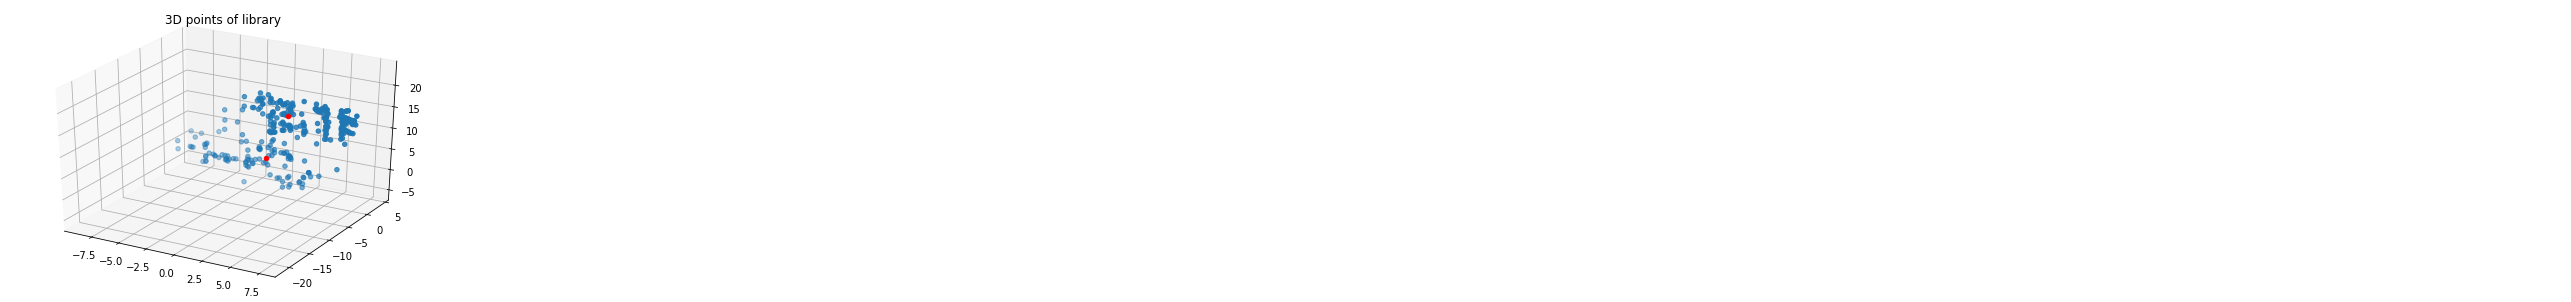

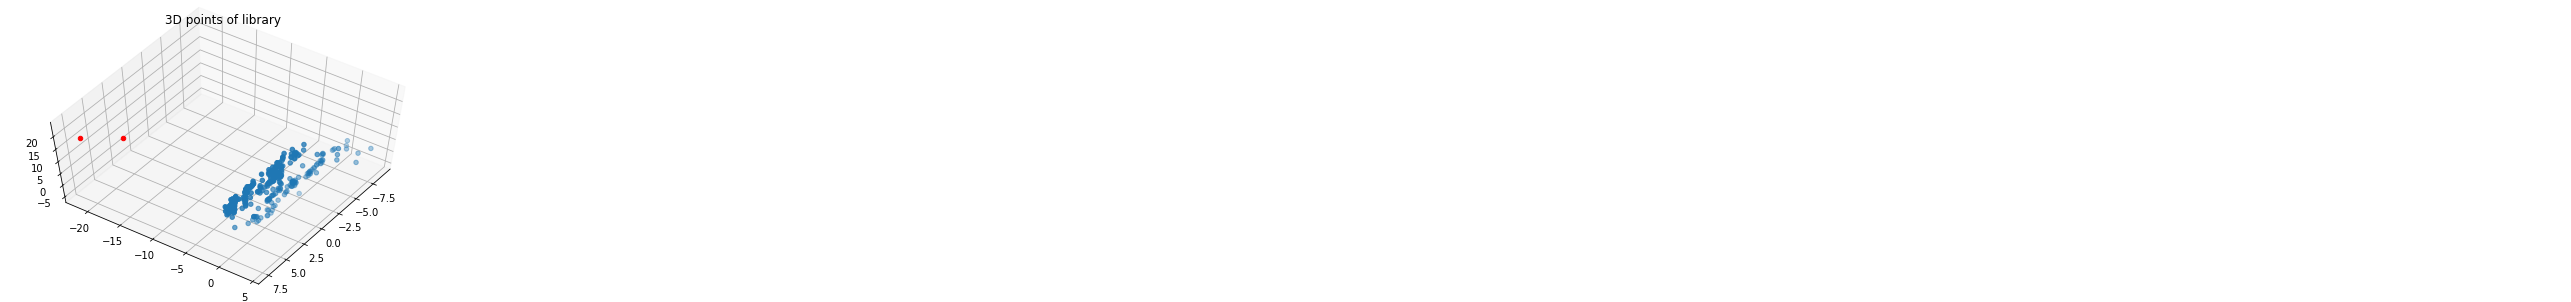

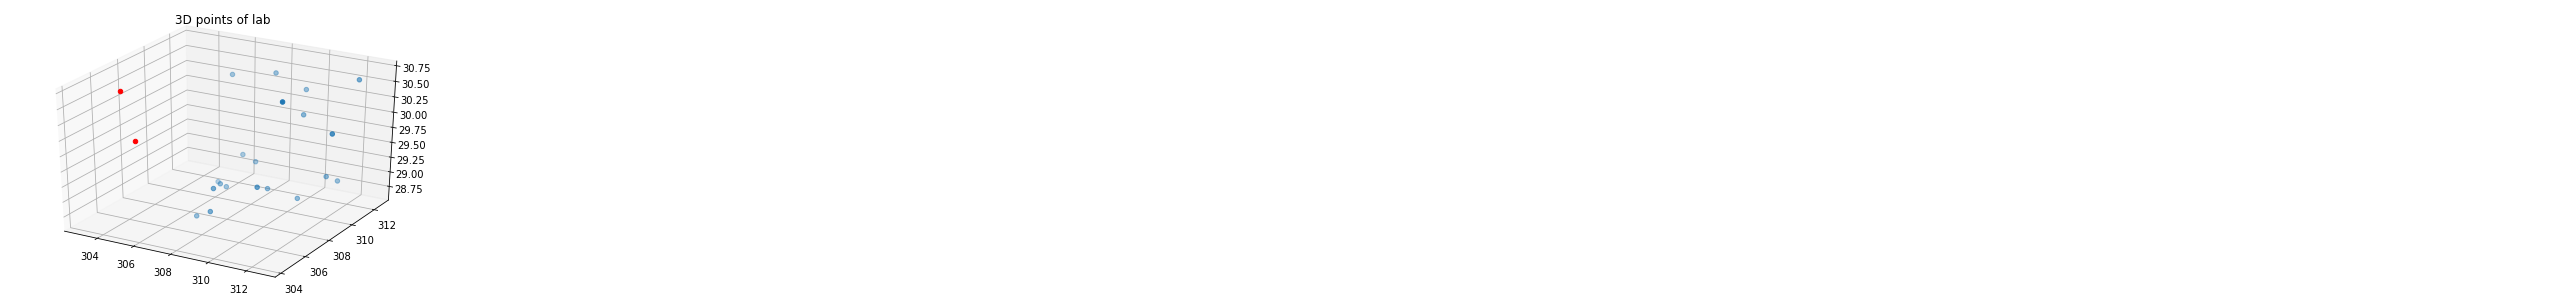

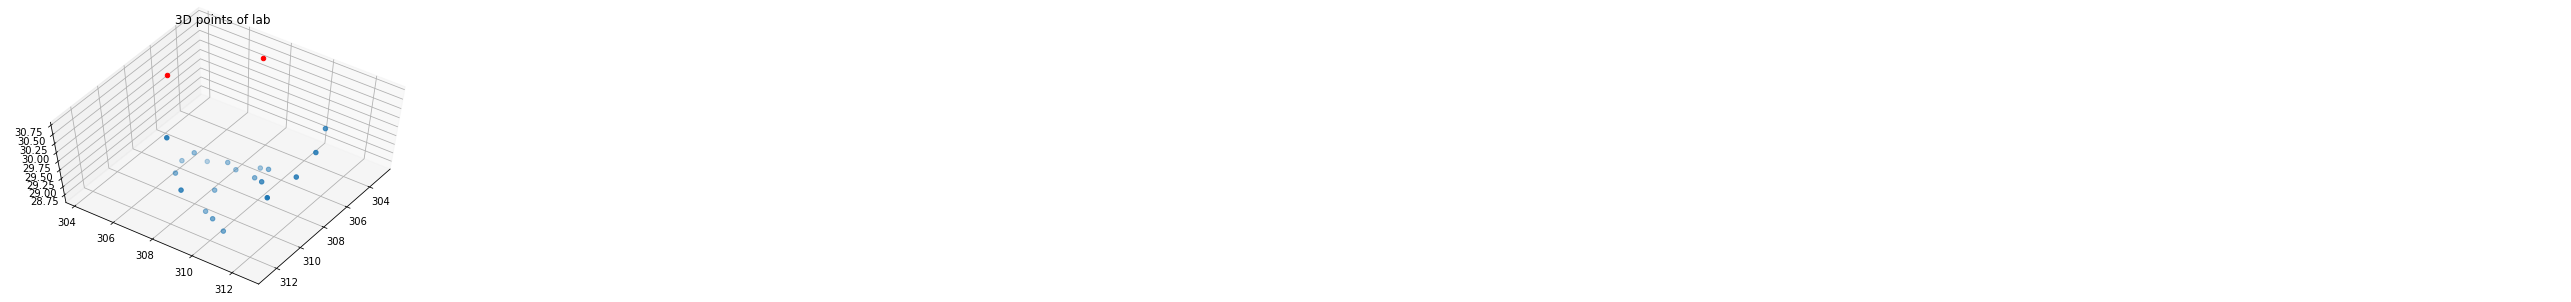

In [238]:
from mpl_toolkits.mplot3d import Axes3D

def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

def ransac_calibration(indices, threshold, max_iterations=300000):
    
    def augment(data):
        aug_data = np.ones((data.shape[0], data.shape[1]+1), dtype=np.float64)
        aug_data[:,:data.shape[1]] = data
        return aug_data

    def is_inlier(model, x, x_p, threshold=threshold):
        tf_x = model @ x
        tf_x /= tf_x[-1]
        return np.sum((tf_x - x_p)**2) <= threshold**2
        
    num_points = len(indices)
    max_num_inliers = 0
    min_samples = 6
    x_p, x = augment(indices[:,:2]), augment(indices[:,2:])
    
    # Construct A
    A = np.zeros((2*len(x), 12), dtype=np.float64)
    for i in range(len(x)):
        A[2*i][4:] = np.hstack((x[i], -x_p[i][1]*x[i]))
        A[2*i+1][:4] = x[i]
        A[2*i+1][8:] = -x_p[i][0]*x[i]
    # print(A)
    
    # Adaptive RANSAC
    N = float('inf')
    sample_count = 0
    N= 1
    optim_model = None
    optim_inliers_idx = []
    while N > sample_count and sample_count < max_iterations:
        rand_index = random.sample(range(num_points), min_samples)
        
        # Solve for Ah = 0
        # Construct A_sample
        A_sample = np.zeros((2 * min_samples, 12), dtype=np.float64)
        for i in range(min_samples):
            A_sample[2*i:2*i+2] = A[2*rand_index[i]:2*rand_index[i]+2]
        
        # Get the eigenvector lf A^TA corresponding to the smallest eigenvalue
        # This is equivalent to get the vector in V (SVD of A) corresponding to the smallest singular value
        model = np.linalg.svd(A_sample)[-1][-1,:].reshape((3, 4))
        
        # normalize the last element of the model to 1, it seems unnecessary? 
        model /= model[-1][-1]
        # print(model)
        
        num_inliers = 0
        for i in range(num_points):
            if is_inlier(model, x[i], x_p[i], threshold):
                num_inliers += 1
        
        if num_inliers > max_num_inliers:
            max_num_inliers = num_inliers
            optim_model = model
            N = np.log(0.05) / np.log(1 - np.power(num_inliers / num_points, min_samples))
        sample_count += 1
    
    
    for i in range(num_points):
        if is_inlier(optim_model, x[i], x_p[i], threshold):
                optim_inliers_idx.append(i)
                
    # Refit all inliers
    A_sample = np.zeros((2 * len(optim_inliers_idx), 12), dtype=np.float64)
    for i in range(len(optim_inliers_idx)):
        A_sample[2*i:2*i+2] = A[2*optim_inliers_idx[i]:2*optim_inliers_idx[i]+2]
    optim_model = np.linalg.svd(A_sample)[-1][-1,:].reshape((3, 4))
        
    return optim_model, np.array(optim_inliers_idx)


lab_matches = np.loadtxt("lab_matches.txt")
lib_matches = np.loadtxt("library_matches.txt")
lab_3d = np.loadtxt('lab_3d.txt')

lab_P1, _ = ransac_calibration(np.c_[lab_matches[:, :2], lab_3d], 2)
lab_P2, _ = ransac_calibration(np.c_[lab_matches[:, 2:], lab_3d], 2)
_, res = evaluate_points(lab_P1, lab_matches[:, :2], lab_3d)
print("Residual of fisrt projected 3d points of lab :", res / len(lab_matches))
_, res = evaluate_points(lab_P2, lab_matches[:, 2:], lab_3d)
print("Residual of second projected 3d points of lab :", res / len(lab_matches))

_, _, vh_lab1 = np.linalg.svd(lab_P1)
_, _, vh_lab2, = np.linalg.svd(lab_P2)
center_lab1, center_lab2 = vh_lab1[-1], vh_lab2[-1]
center_lab1 /= center_lab1[-1]
center_lab2 /= center_lab2[-1]

lib_P1 = np.loadtxt("library1_camera.txt")
lib_P2 = np.loadtxt("library2_camera.txt")
_, _, vh_lib1 = np.linalg.svd(lib_P1)
_, _, vh_lib2 = np.linalg.svd(lib_P2)
center_lib1, center_lib2 = vh_lib1[-1], vh_lib2[-1]
center_lib1 /= center_lib1[-1]
center_lib2 /= center_lib2[-1]


def triangulation(matches, Ps):
    C = Ps.shape[0]
    N = matches.shape[0]
    points_3d = np.empty((N, 3))
    for i in range(N):
        X = np.empty((2 * C, 4))
        for j in range(C):
            X[2 * j:2 * j + 2] = np.array([[0, -1, matches[i][2 * j + 1]],\
                                 [1, 0, -matches[i][2 * j]]]) @ Ps[j]
#         print(matches[0])
#         print(Ps[0])
#         print(Ps[1])
#         print(X)
        x3d_homo = np.linalg.svd(X)[-1][-1, :]
        x3d_homo /= x3d_homo[-1]
        points_3d[i] = x3d_homo[:3]
    return points_3d
        
    

P_lab = np.stack((lab_P1, lab_P2))
lab_3d_estimate = triangulation(lab_matches, P_lab)
lab_3d_residual = np.mean((lab_3d_estimate - lab_3d) ** 2)
print("Residual of 3d points of lab :", lab_3d_residual)

P_lib = np.stack((lib_P1, lib_P2))
lib_3d_estimate = triangulation(lib_matches, P_lib)

_, lib_2d_residual1 = evaluate_points(lib_P1, lib_matches[:, :2], lib_3d_estimate)
_, lib_2d_residual2 = evaluate_points(lib_P2, lib_matches[:, 2:], lib_3d_estimate)

print("Residual of fisrt projected triangulation 3d points of library :", lib_2d_residual1 / lib_matches.shape[0])
print("Residual of second projected triangulation 3d points of library :", lib_2d_residual2 / lib_matches.shape[0])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(lib_3d_estimate[:, 0], lib_3d_estimate[:, 1], lib_3d_estimate[:, 2])
ax.scatter(center_lib1[0], center_lib1[1], center_lib1[2], c='r')
ax.scatter(center_lib2[0], center_lib2[1], center_lib2[2], c='r')
plt.title("3D points of library")
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(lib_3d_estimate[:, 0], lib_3d_estimate[:, 1], lib_3d_estimate[:, 2])
ax.scatter(center_lib1[0], center_lib1[1], center_lib1[2], c='r')
ax.scatter(center_lib2[0], center_lib2[1], center_lib2[2], c='r')
ax.view_init(60, 35)
plt.title("3D points of library")
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(lab_3d_estimate[:, 0], lab_3d_estimate[:, 1], lab_3d_estimate[:, 2])
ax.scatter(center_lab1[0], center_lab1[1], center_lab1[2], c='r')
ax.scatter(center_lab2[0], center_lab2[1], center_lab2[2], c='r')
plt.title("3D points of lab")
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(lab_3d_estimate[:, 0], lab_3d_estimate[:, 1], lab_3d_estimate[:, 2])
ax.scatter(center_lab1[0], center_lab1[1], center_lab1[2], c='r')
ax.scatter(center_lab2[0], center_lab2[1], center_lab2[2], c='r')
ax.view_init(60, 35)
plt.title("3D points of lab")
plt.show()

In [199]:
214 * 1.67545415e-06 - 3.05502358e-04


5.30448301e-05

In [230]:
print(center_lab1)

[305.80577238 304.17310446  30.14407753   1.        ]
